Plotting the mean probabilities of all 10 runs for each distribution according to the best individual

In [61]:
import os
import re
import pandas as pd
import numpy as np
import pickle as pkl
from experiments import get_state
from itertools import product
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from experiments.util import load_circuit
from sanchez_ansatz import SanchezAnsatz
from scipy.stats import entropy
import matplotlib.pyplot as plt

num_qubits = 15
eps = 0.05

RESULTS_DIR = "results/genetic/distributions_full_training"
x_operations = ["cycle", "order", "pmx"]
mut_operations = ["insert", "inverse", "scramble"]

In [62]:
def get_statevector(ansatz: QuantumCircuit):
    sv_sim = Aer.get_backend("statevector_simulator")
    job = sv_sim.run(ansatz)
    result = job.result()
    statevector = result.get_statevector()
    return statevector.data

def get_best_individual(inividual_path: str): 
    df = pd.read_csv(inividual_path, header=None)
    digits = re.findall(r"\d+", df.iloc[-1].values[0])
    digits = [int(d) for d in digits]
    return digits


def compute_best_individual(
        target_state: np.ndarray, 
        n_runs: int, 
        num_qubits: int,
        eps: float,
        dist_name: str, 
        x_op: str,
        mut_op: str):

    exp_dir = os.path.join(RESULTS_DIR, f"{dist_name}_{x_op}_{mut_op}")

    o_ansatz = SanchezAnsatz(target_state=target_state, eps=eps)

    m_ansatz = SanchezAnsatz(target_state=target_state, eps=eps, build_modified=True)

    original_outputs = []
    modified_outputs = []

    for run_idx in range(1, n_runs+1): 

        # run directory
        run_dir = os.path.join(exp_dir, f"run_{run_idx}")

        # loading best individuals
        best_individuals_original_path = os.path.join(run_dir, "csv", f"original_best_individual_{num_qubits}qb_{eps}eps.csv")
        best_individual_original = get_best_individual(best_individuals_original_path)

        t_o_ansatz = transpile(o_ansatz, basis_gates=["cx", "u"], initial_layout=best_individual_original)

        best_individuals_modified_path = os.path.join(run_dir, "csv", f"modified_best_individual_{num_qubits}qb_{eps}eps.csv")
        best_individual_modified = get_best_individual(best_individuals_modified_path)

        t_m_ansatz = transpile(m_ansatz, basis_gates=["cx", "u"], initial_layout=best_individual_modified)


        # loading best individuals parameters
        best_params_original_path = os.path.join(run_dir, "csv", f"original_best_individual_params_{num_qubits}qb_{eps}eps.csv")
        best_params_original = np.loadtxt(best_params_original_path, delimiter=",")

        best_params_modified_path = os.path.join(run_dir, "csv", f"modified_best_individual_params_{num_qubits}qb_{eps}eps.csv")
        best_params_modified = np.loadtxt(best_params_modified_path, delimiter=",")

        # running simulations
        try: 
            t_o_ansatz_params = t_o_ansatz.assign_parameters(best_params_original[-1])
            t_m_ansatz_params = t_m_ansatz.assign_parameters(best_params_modified[-1])
        except: 
            print("Error")

        # getting outputs
        o_output = get_statevector(t_o_ansatz_params)
        m_output = get_statevector(t_m_ansatz_params)

        original_outputs.append(o_output)
        modified_outputs.append(m_output)

    original_outputs = np.array(original_outputs)
    modified_outputs = np.array(modified_outputs)

    return original_outputs, modified_outputs

#### $log$-Normal $(\mu = 0.1, \sigma = 0.3)$

In [63]:
x_points = (0, 1)
mu = .1
sig = .3

target_state = get_state(num_qubits, state_type="lognormal", state_params={"x_points": x_points, "s": 1, "loc": mu, "scale": sig})

In [64]:
n_runs = 10
num_qubits = 15
eps = 0.05
dist_name = "lognormal"
x_op = "order"
mut_op = "scramble"

original_outputs, modified_outputs = compute_best_individual(target_state, n_runs, num_qubits, eps, dist_name, x_op, mut_op)

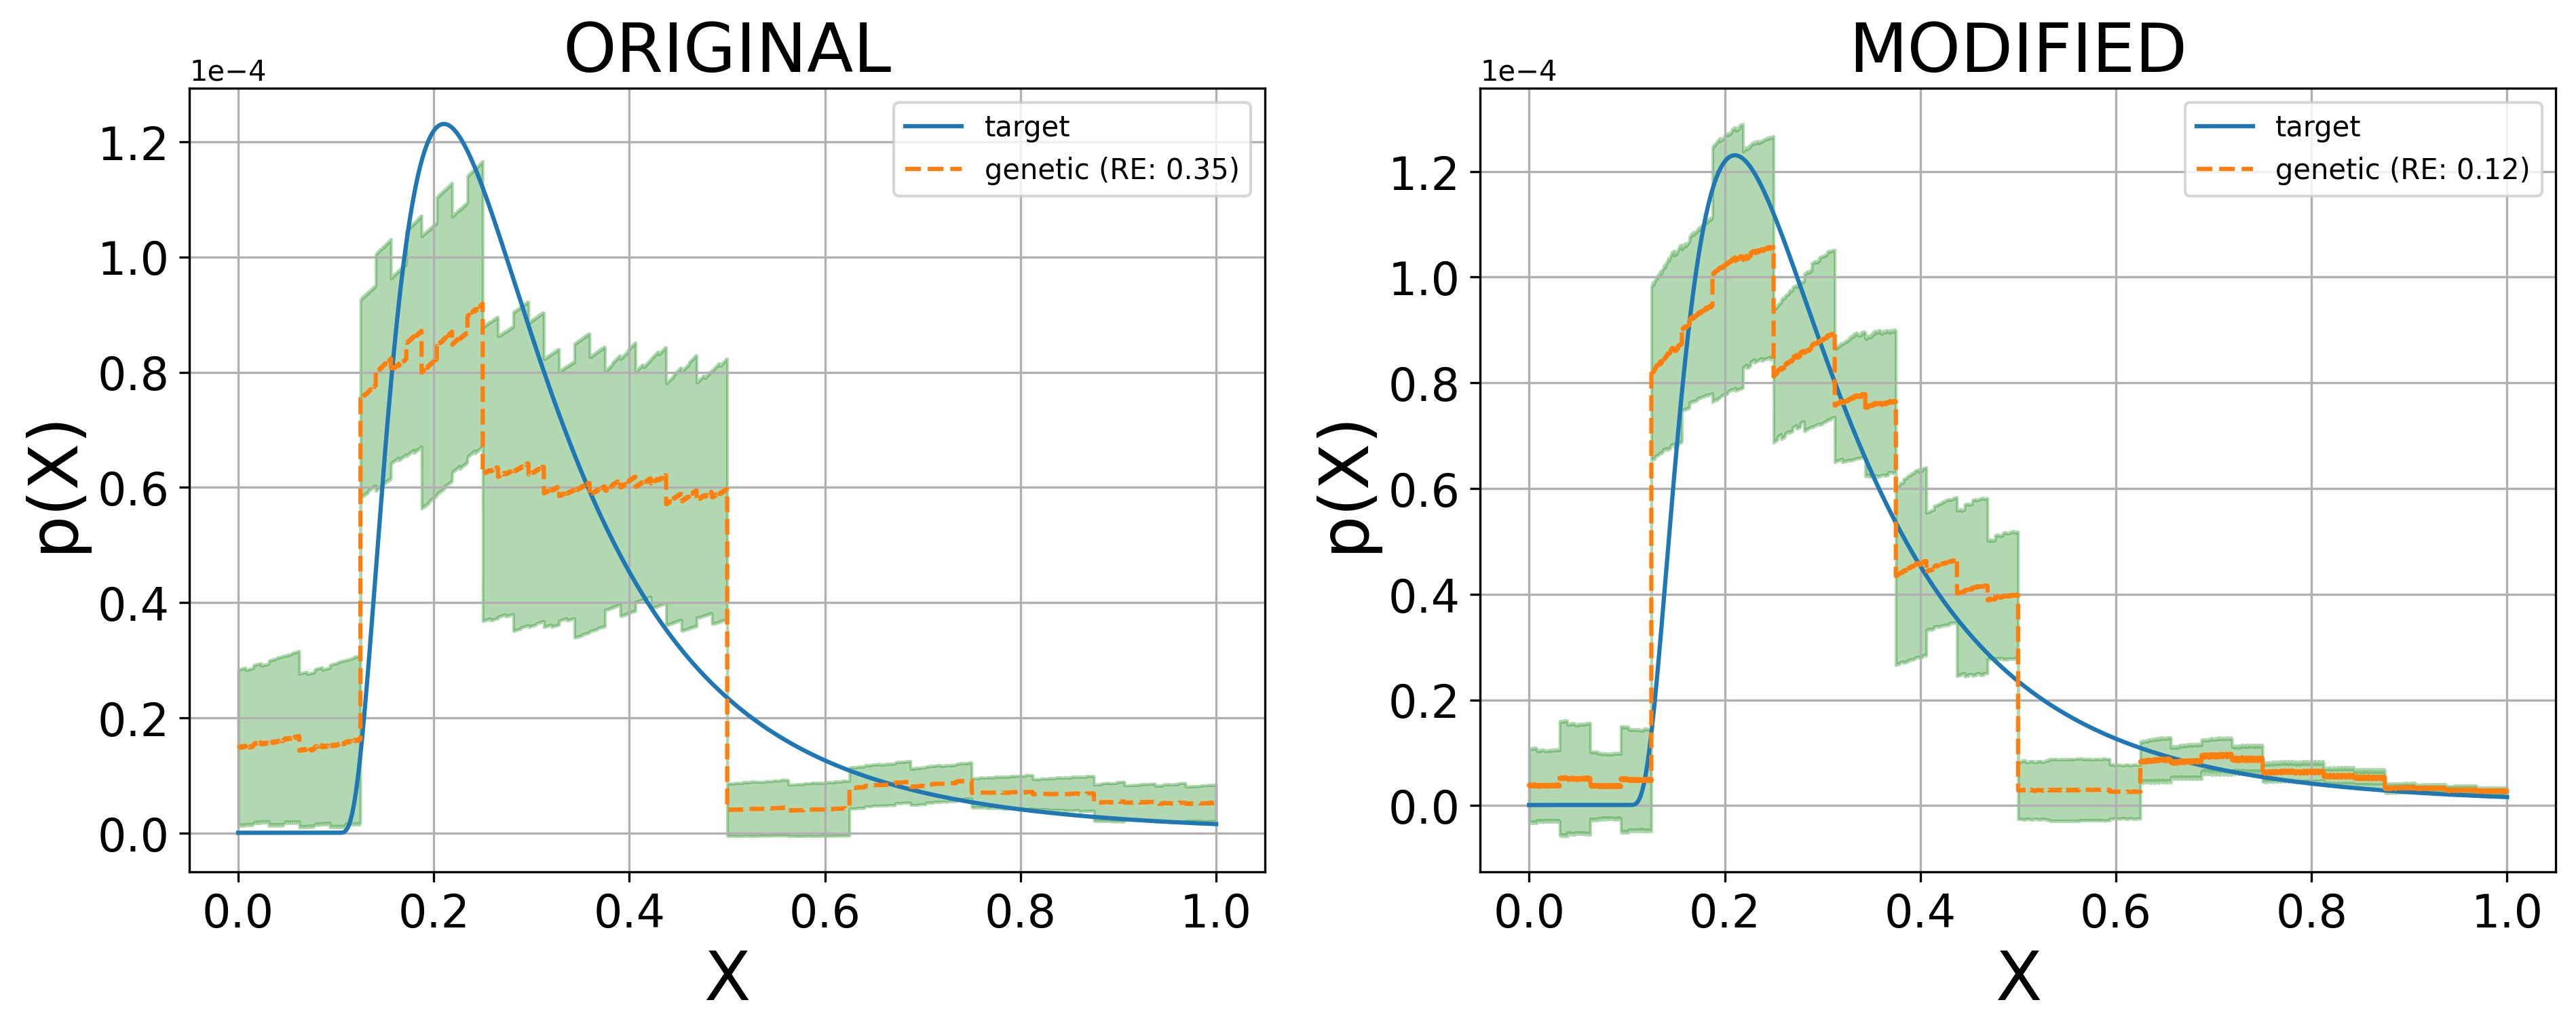

In [65]:
target_freqs = np.abs(target_state)**2 + 1e-7

freqs_original = np.abs(original_outputs)**2
freqs_modified = np.abs(modified_outputs)**2

mean_original = np.mean(freqs_original, axis=0) + 1e-7
std_original = np.std(freqs_original, axis=0) + 1e-7

mean_modified = np.mean(freqs_modified, axis=0) + 1e-7
std_modified = np.std(freqs_modified, axis=0) + 1e-7

og_entropy = entropy(mean_original, target_freqs)
mod_entropy = entropy(mean_modified, target_freqs)

x = np.linspace(*x_points, num=2**num_qubits)

label_fontsize = 24
tick_fontsize = 16
alpha = .3
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
axes[0].set_title("ORIGINAL", fontsize=label_fontsize)
axes[0].plot(x, target_freqs, label="target")
axes[0].plot(x, mean_original, "--", label=f"genetic (RE: {round(og_entropy, 2)})")
axes[0].fill_between(x, mean_original+std_original, mean_original-std_original, alpha=alpha, color="green")
axes[0].legend(loc="best")
axes[0].set_xlabel("X", fontsize=label_fontsize)
axes[0].set_ylabel("p(X)", fontsize=label_fontsize)
axes[0].tick_params(labelsize=tick_fontsize)
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].grid()

axes[1].set_title("MODIFIED", fontsize=label_fontsize)
axes[1].plot(x, target_freqs, label="target")
axes[1].plot(x, mean_modified,"--", label=f"genetic (RE: {round(mod_entropy, 2)})")
axes[1].fill_between(x, mean_modified+std_modified, mean_modified-std_modified, alpha=alpha, color="green")
axes[1].legend(loc="best")
axes[1].set_xlabel("X", fontsize=label_fontsize)
axes[1].set_ylabel("p(X)", fontsize=label_fontsize)
axes[1].tick_params(labelsize=tick_fontsize)
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].grid()

### Bimodal $(\mu_1 = 0.25, \sigma = 0.1 ; \mu_2 = 0.75, \sigma_2 = 0.15)$

In [66]:
x_points = (0, 1)
mu_1 = .25
sig_1 = .1
mu_2 = .75
sig_2 = .15


target_state = get_state(num_qubits, state_type="bimodal", state_params={"x_points": x_points, "loc_bim1": mu_1, "scale_bim1": sig_1, "loc_bim2": mu_2, "scale_bim2": sig_2})

In [67]:
n_runs = 10
num_qubits = 15
eps = 0.05
dist_name = "bimodal"
x_op = "order"
mut_op = "scramble"

original_outputs, modified_outputs = compute_best_individual(target_state, n_runs, num_qubits, eps, dist_name, x_op, mut_op)

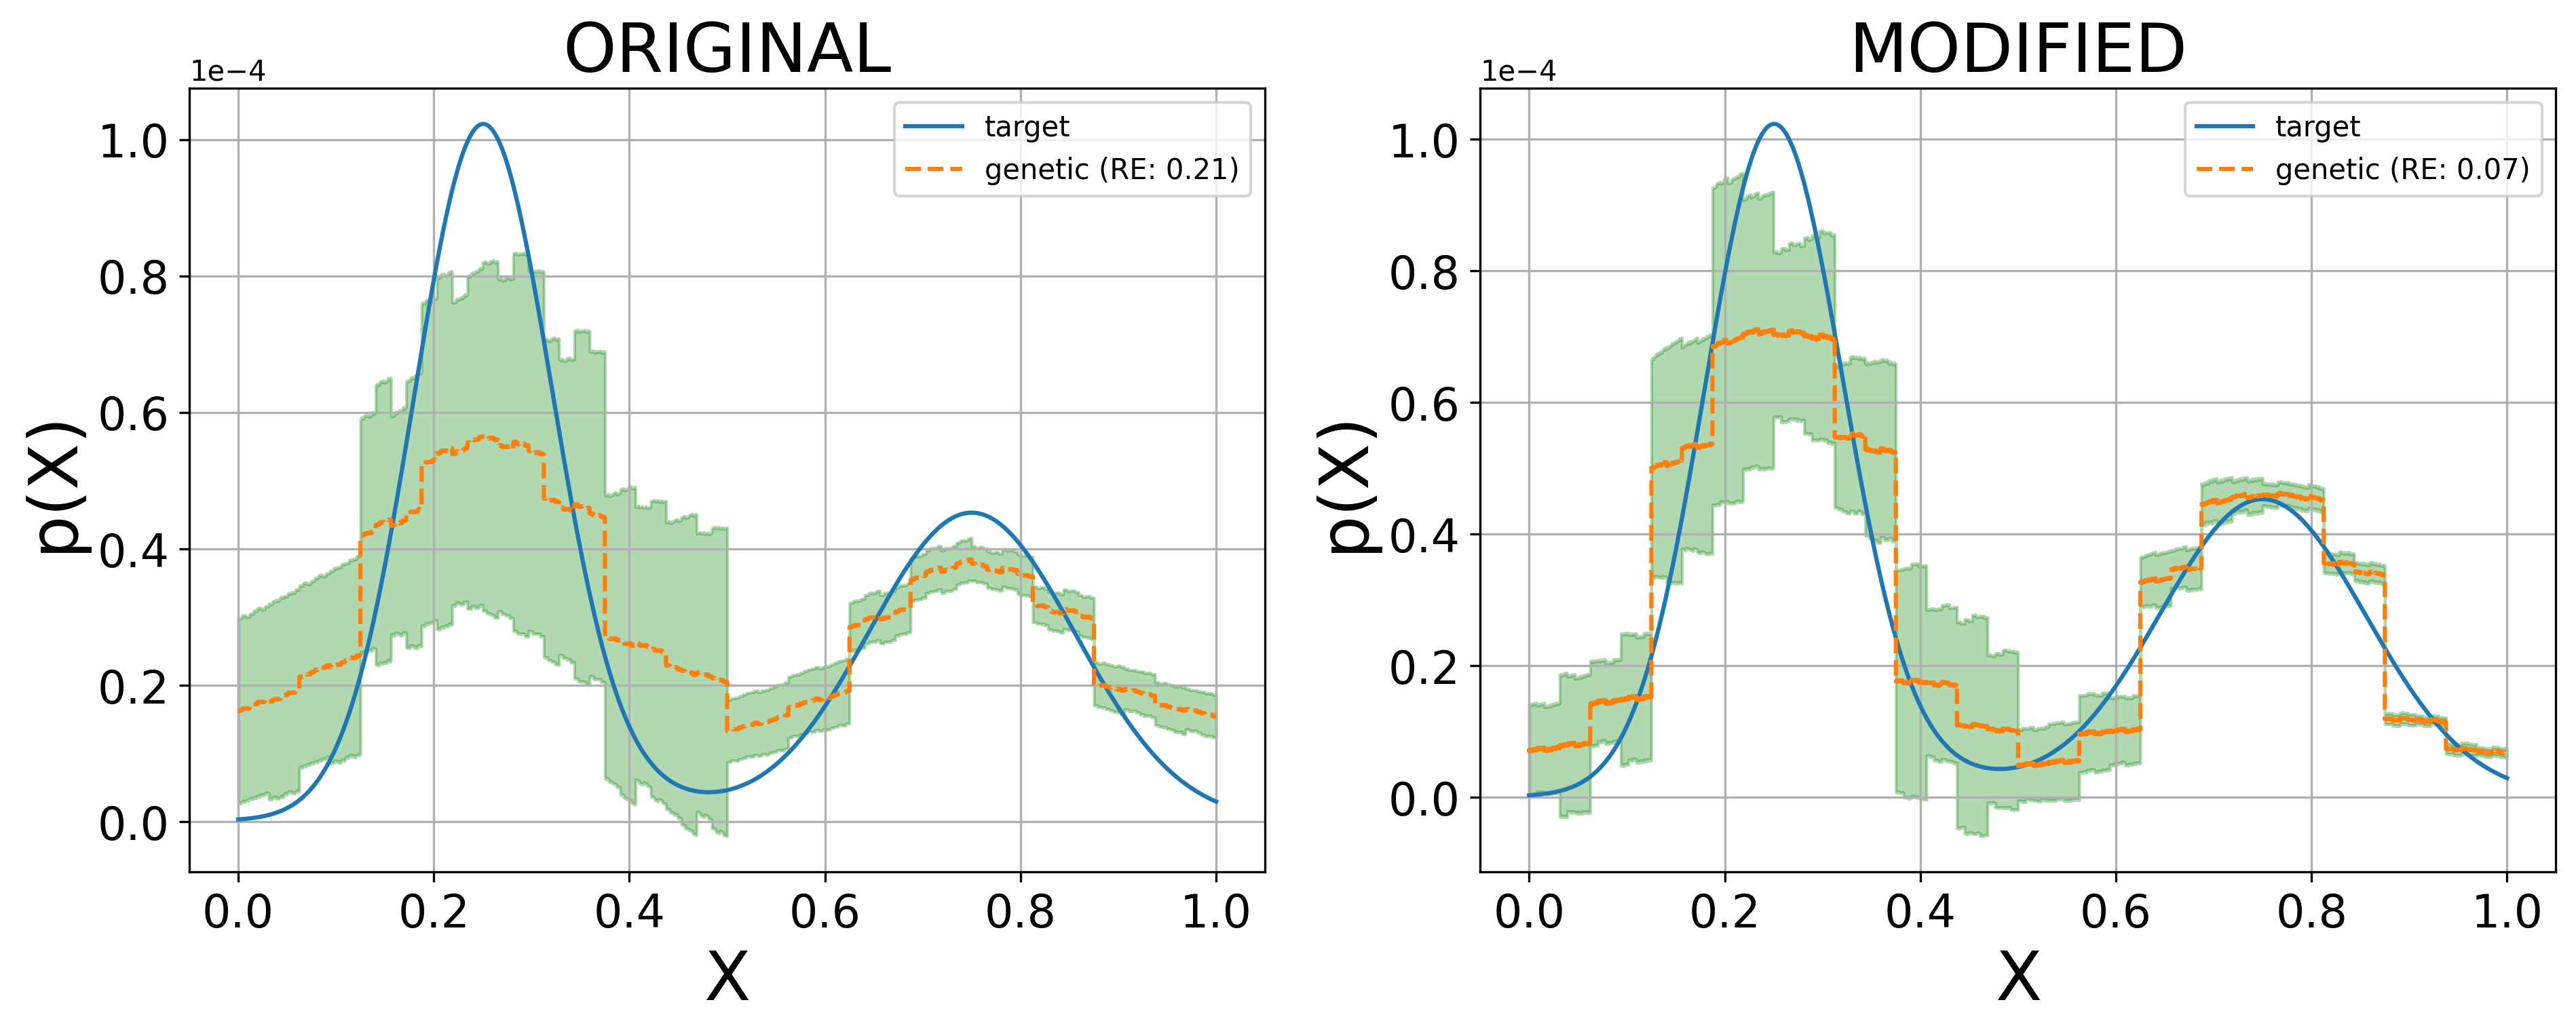

In [68]:
target_freqs = np.abs(target_state)**2 + 1e-7

freqs_original = np.abs(original_outputs)**2
freqs_modified = np.abs(modified_outputs)**2

mean_original = np.mean(freqs_original, axis=0) + 1e-7
mean_modified = np.mean(freqs_modified, axis=0) + 1e-7

og_entropy = entropy(mean_original, target_freqs)
mod_entropy = entropy(mean_modified, target_freqs)

x = np.linspace(*x_points, num=2**num_qubits)

label_fontsize = 24
tick_fontsize = 16
alpha = .3
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
axes[0].set_title("ORIGINAL", fontsize=label_fontsize)
axes[0].plot(x, target_freqs, label="target")
axes[0].plot(x, mean_original,"--", label=f"genetic (RE: {round(og_entropy, 2)})")
axes[0].fill_between(x, mean_original+std_original, mean_original-std_original, alpha=alpha, color="green")
axes[0].legend(loc="best")
axes[0].set_xlabel("X", fontsize=label_fontsize)
axes[0].set_ylabel("p(X)", fontsize=label_fontsize)
axes[0].tick_params(labelsize=tick_fontsize)
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].grid()

axes[1].set_title("MODIFIED", fontsize=label_fontsize)
axes[1].plot(x, target_freqs, label="target")
axes[1].plot(x, mean_modified, "--", label=f"genetic (RE: {round(mod_entropy, 2)})")
axes[1].fill_between(x, mean_modified+std_modified, mean_modified-std_modified, alpha=alpha, color="green")
axes[1].legend(loc="best")
axes[1].set_xlabel("X", fontsize=label_fontsize)
axes[1].set_ylabel("p(X)", fontsize=label_fontsize)
axes[1].tick_params(labelsize=tick_fontsize)
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].grid()

### Normal $(\mu = 0.5 , \sigma = 0.3)$

In [69]:
x_points = (0, 1)
mu = .5
sig = .3

target_state = get_state(num_qubits, state_type="normal", state_params={"x_points": x_points, "loc": mu, "scale": sig})

In [70]:
n_runs = 10
num_qubits = 15
eps = 0.05
dist_name = "normal"
x_op = "cycle"
mut_op = "scramble"

original_outputs, modified_outputs = compute_best_individual(target_state, n_runs, num_qubits, eps, dist_name, x_op, mut_op)

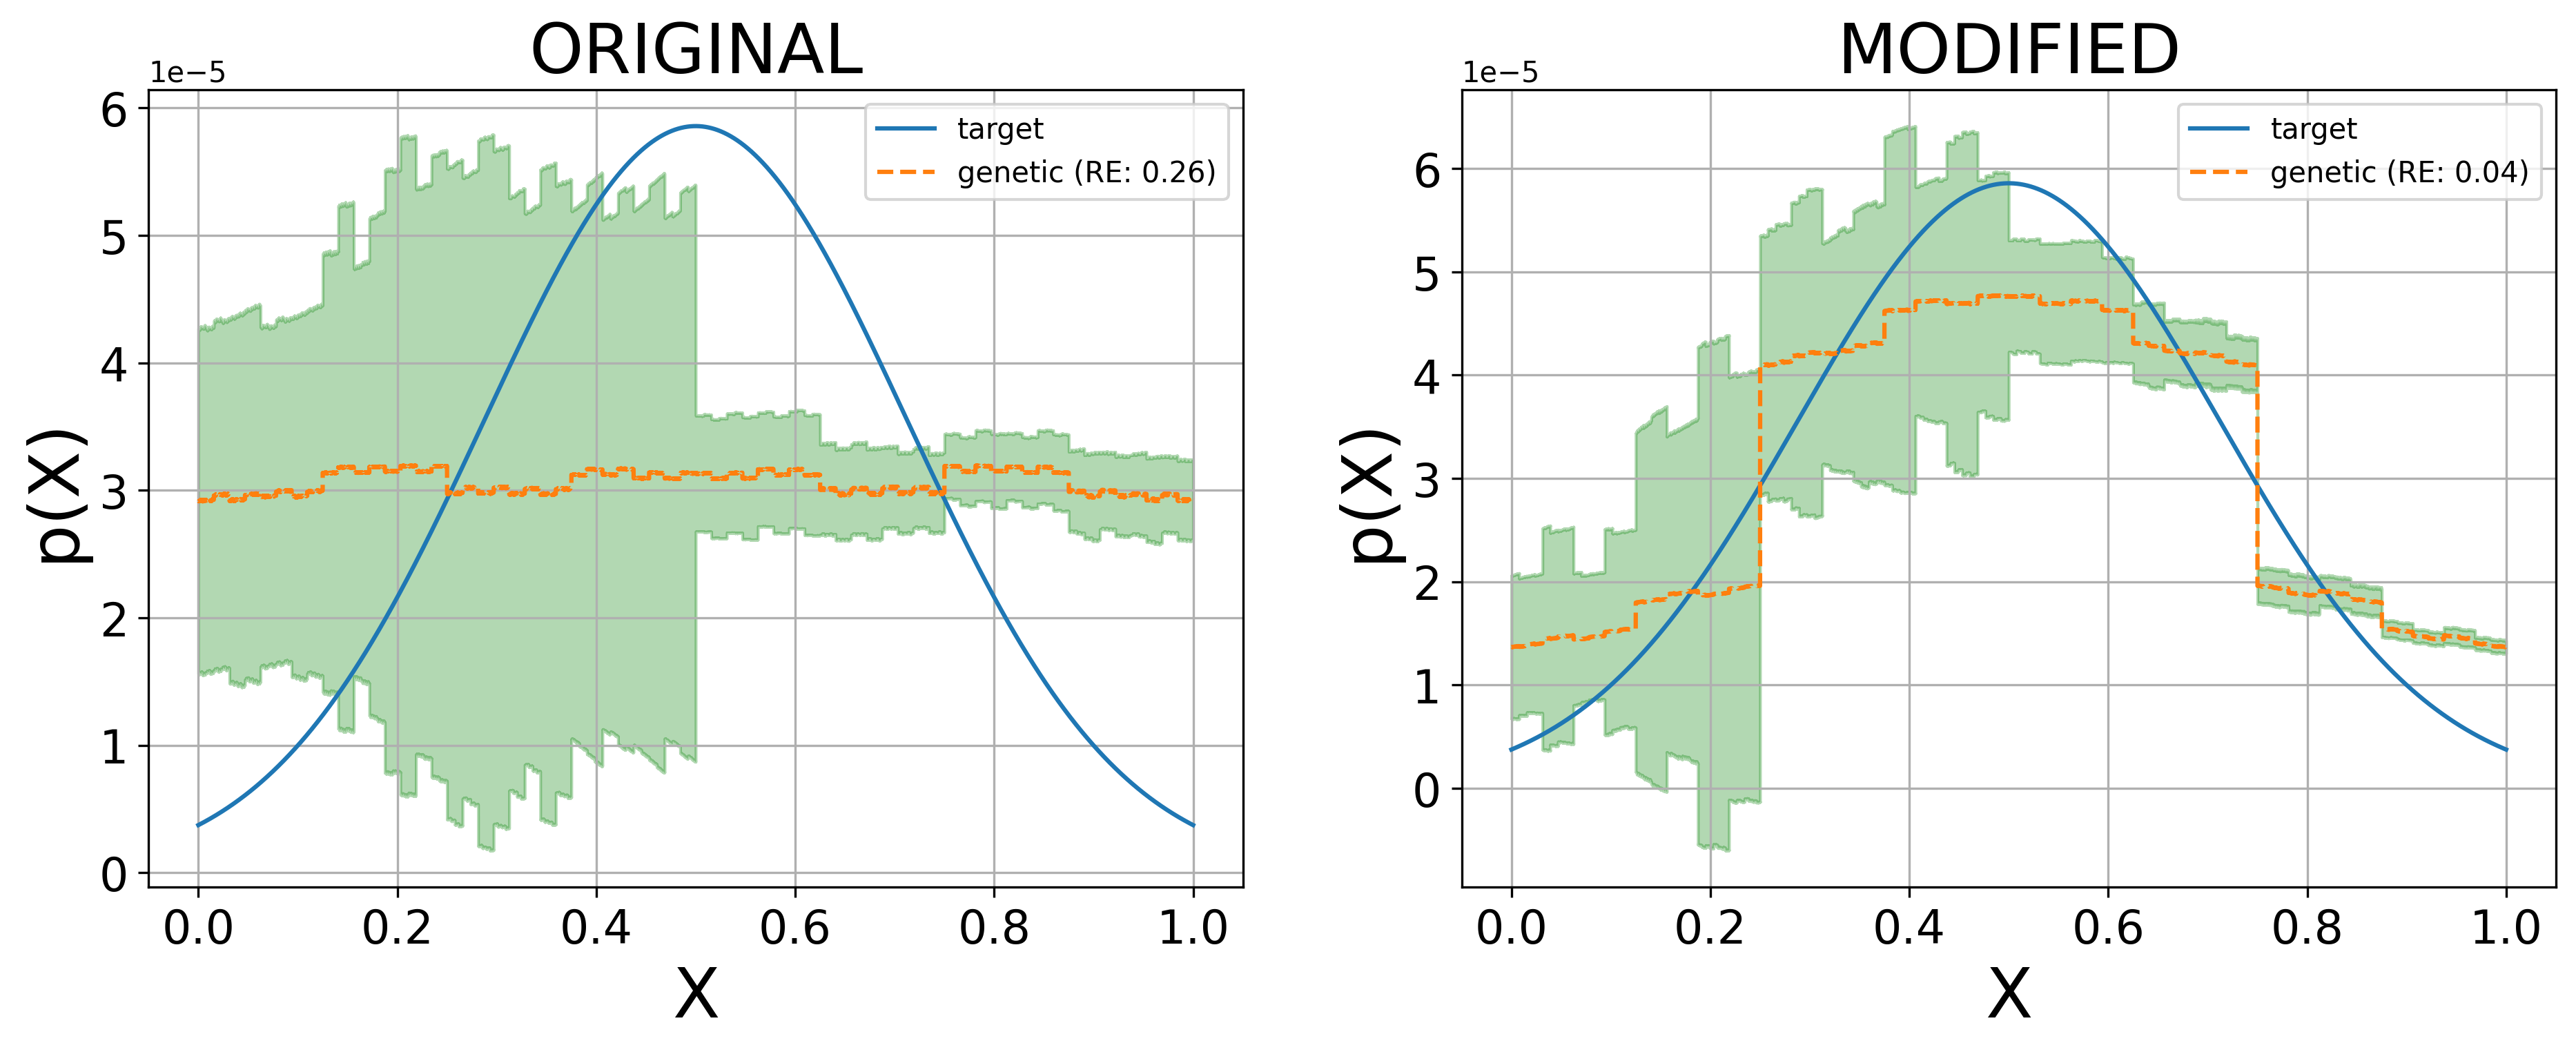

In [71]:
target_freqs = np.abs(target_state)**2 + 1e-7

freqs_original = np.abs(original_outputs)**2
freqs_modified = np.abs(modified_outputs)**2

mean_original = np.mean(freqs_original, axis=0) + 1e-7
mean_modified = np.mean(freqs_modified, axis=0) + 1e-7

og_entropy = entropy(mean_original, target_freqs)
mod_entropy = entropy(mean_modified, target_freqs)

x = np.linspace(*x_points, num=2**num_qubits)

label_fontsize = 24
tick_fontsize = 16
alpha = .3
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
axes[0].set_title("ORIGINAL", fontsize=label_fontsize)
axes[0].plot(x, target_freqs, label="target")
axes[0].plot(x, mean_original, "--", label=f"genetic (RE: {round(og_entropy, 2)})")
axes[0].fill_between(x, mean_original+std_original, mean_original-std_original, alpha=alpha, color="green")
axes[0].legend(loc="best")
axes[0].set_xlabel("X", fontsize=label_fontsize)
axes[0].set_ylabel("p(X)", fontsize=label_fontsize)
axes[0].tick_params(labelsize=tick_fontsize)
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].grid()

axes[1].set_title("MODIFIED", fontsize=label_fontsize)
axes[1].plot(x, target_freqs, label="target")
axes[1].plot(x, mean_modified, "--", label=f"genetic (RE: {round(mod_entropy, 2)})")
axes[1].fill_between(x, mean_modified+std_modified, mean_modified-std_modified, alpha=alpha, color="green")
axes[1].legend(loc="best")
axes[1].set_xlabel("X", fontsize=label_fontsize)
axes[1].set_ylabel("p(X)", fontsize=label_fontsize)
axes[1].tick_params(labelsize=tick_fontsize)
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].grid()

### Laplace $(\mu = 0.5, \sigma =  0.2)$

In [72]:
x_points = (0, 1)
mu = .5
sig = .2

target_state = get_state(num_qubits, state_type="laplace", state_params={"x_points": x_points, "loc": mu, "scale": sig})

In [73]:
n_runs = 10
num_qubits = 15
eps = 0.05
dist_name = "laplace"
x_op = "pmx"
mut_op = "inverse"

original_outputs, modified_outputs = compute_best_individual(target_state, n_runs, num_qubits, eps, dist_name, x_op, mut_op)

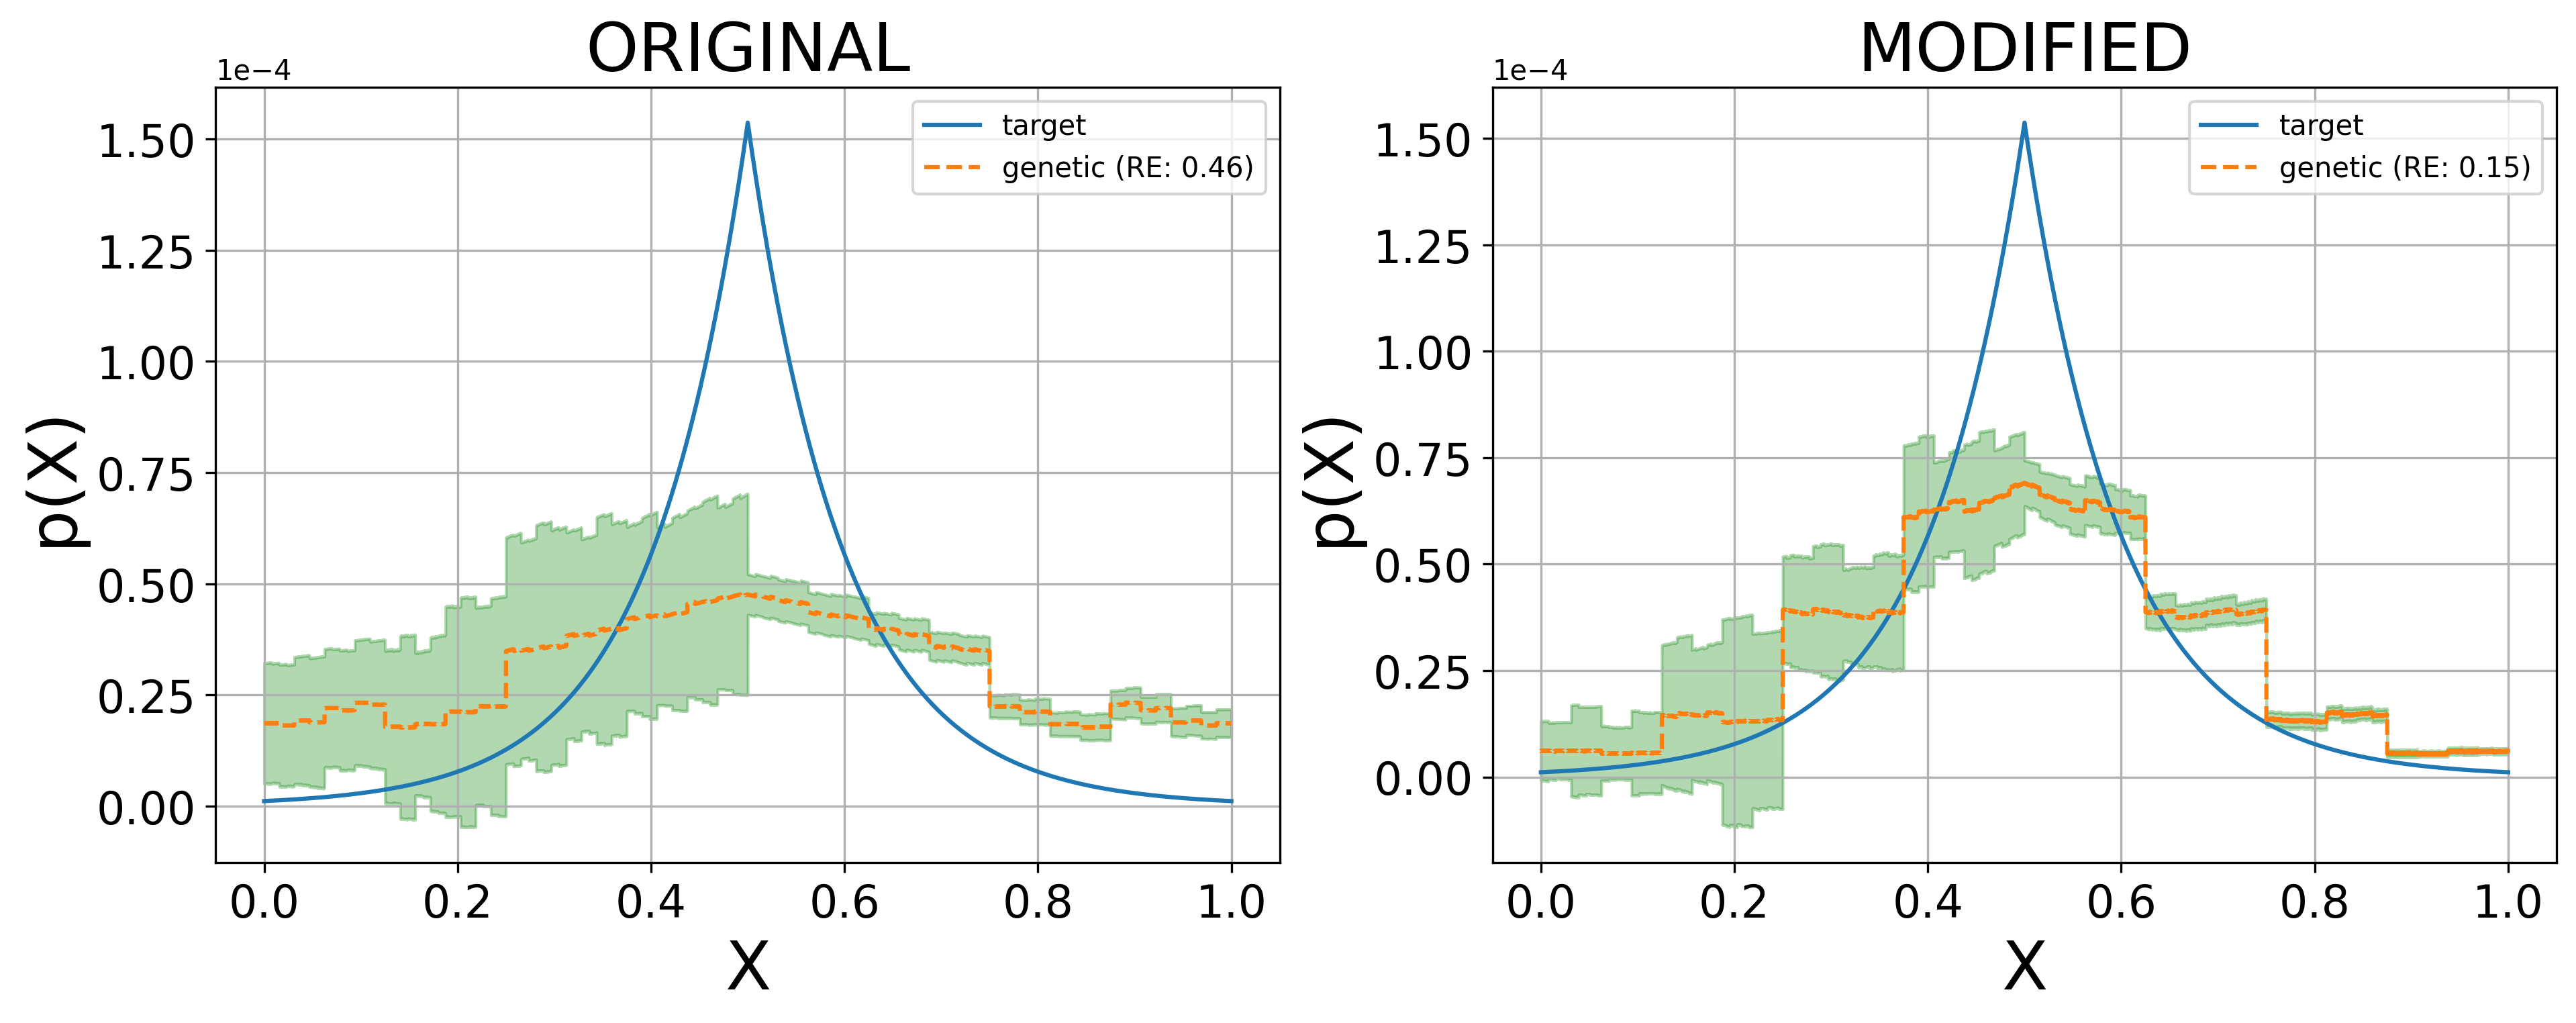

In [74]:
target_freqs = np.abs(target_state)**2 + 1e-7

freqs_original = np.abs(original_outputs)**2
freqs_modified = np.abs(modified_outputs)**2

mean_original = np.mean(freqs_original, axis=0) + 1e-7
mean_modified = np.mean(freqs_modified, axis=0) + 1e-7

og_entropy = entropy(mean_original, target_freqs)
mod_entropy = entropy(mean_modified, target_freqs)

x = np.linspace(*x_points, num=2**num_qubits)

label_fontsize = 24
tick_fontsize = 16
alpha = .3
fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
axes[0].set_title("ORIGINAL", fontsize=label_fontsize)
axes[0].plot(x, target_freqs, label="target")
axes[0].plot(x, mean_original, "--", label=f"genetic (RE: {round(og_entropy, 2)})")
axes[0].fill_between(x, mean_original+std_original, mean_original-std_original, alpha=alpha, color="green")
axes[0].legend(loc="best")
axes[0].set_xlabel("X", fontsize=label_fontsize)
axes[0].set_ylabel("p(X)", fontsize=label_fontsize)
axes[0].tick_params(labelsize=tick_fontsize)
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[0].grid()

axes[1].set_title("MODIFIED", fontsize=label_fontsize)
axes[1].plot(x, target_freqs, label="target")
axes[1].plot(x, mean_modified, "--", label=f"genetic (RE: {round(mod_entropy, 2)})")
axes[1].fill_between(x, mean_modified+std_modified, mean_modified-std_modified, alpha=alpha, color="green")
axes[1].legend(loc="best")
axes[1].set_xlabel("X", fontsize=label_fontsize)
axes[1].set_ylabel("p(X)", fontsize=label_fontsize)
axes[1].tick_params(labelsize=tick_fontsize)
axes[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axes[1].grid()